In [36]:
import os
import pandas as pd
import regex
import re
import numpy as np
import requests
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from bs4 import BeautifulSoup
from transformers import pipeline
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [37]:
# Preprocesarea textului
def remove_punc(text):
    """Elimină semnele de punctuație din text."""
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_emojis(text):
    """Elimină emoji-urile din text."""
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return emoji_pattern.sub('', text)

def remove_url(text):
    """Elimină URL-urile din text."""
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

def remove_stopwords(text):
    """Elimină stopword-urile din text."""
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

def replace_abbreviations(text, abbreviation_dict):
    """Înlocuiește abrevierile cu forma completă."""
    for abbreviation, full_form in abbreviation_dict.items():
        text = text.replace(abbreviation, full_form)
    return text

def preprocess_text(text, abbreviation_dict):
    """Pipeline pentru preprocesarea textului."""
    if not isinstance(text, str) or text.strip() == "":
        return ""
    text = text.lower()
    text = remove_url(text)
    text = remove_emojis(text)
    text = remove_punc(text)
    text = remove_stopwords(text)
    text = replace_abbreviations(text, abbreviation_dict)
    return text


In [38]:
# Generare rezumat folosind Huggingface transformers
def generate_summary(text):
    """Generarea unui rezumat folosind modelul de la Huggingface."""
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    summary = summarizer(text, max_length=150, min_length=50, do_sample=False)
    return summary[0]['summary_text']

In [39]:
# Calea către fișierul CSV
file_path = 'C:\\Users\\djtsms\\Desktop\\Master\\MODUL 2\\Semantica si pragmatica limbajului natural-S1\\Proiect Old Team\\engli_dataet.csv'


In [40]:
# Verifică dacă fișierul există
if not os.path.exists(file_path):
    print(f"Fișierul nu a fost găsit: {file_path}")
    exit()

Fișierul nu a fost găsit: C:\Users\djtsms\Desktop\Master\MODUL 2\Semantica si pragmatica limbajului natural-S1\Proiect Old Team\engli_dataet.csv


In [9]:
# Încărcă datele
df = pd.read_csv(file_path)
# Afișează primele 10 rânduri
print(df.head(10))

                                            Headline  \
0  Congress leader Baljinder Singh shot dead at h...   
1  17-year-old girl preparing for NEET dies by su...   
2  Hampers to welcome MPs in new Parliament tomor...   
3  Only 10% women lawmakers in RS, while only 14%...   
4  Ganesh temple decorated with notes, coins wort...   
5  Bee attack during funeral in K'taka leaves 1 d...   
6  Manipur govt forms inquiry commission to probe...   
7  Cabinet approves Bill giving 33% reservation t...   
8  Won't accept his remains: Wife of Army soldier...   
9  Heavy to very heavy rainfall warning issued fo...   

                                             Content News Categories  \
0  Congress leader Baljinder Singh was shot dead ...    ['national']   
1  Another NEET aspirant died by suicide in Rajas...    ['national']   
2  In order to mark the first-ever working day of...    ['national']   
3  Congress President Mallikarjun Kharge, while s...    ['national']   
4  The Sri Sathya Ganap

In [10]:
# Gruparea claselor rare
threshold = 5
class_counts = df['News Categories'].value_counts()
rare_classes = class_counts[class_counts < threshold].index
df['category_grouped'] = df['News Categories'].apply(lambda x: 'Other' if x in rare_classes else x)


In [11]:
# Dicționar de abrevieri
abbreviation_dict = {
    'LOL': 'laugh out loud',
    'BRB': 'be right back',
    'OMG': 'oh my god',
    'AFAIK': 'as far as I know',
    'AFK': 'away from keyboard',
    'ASAP': 'as soon as possible',
    'ATM': 'at the moment',
    'BTW': 'by the way',
    'FYI': 'For Your Information',
    'IMHO': 'in my honest/humble opinion',
    'IMO': 'in my opinion',
    'IRL': 'in real life',
    'LOL': 'laughing out loud',
    'ROFL': 'rolling on the floor laughing',
    'TTYL': 'talk to you later',
    'WTF': 'what the f...',
    'THX': 'thank you',
    'BFF': 'best friends forever',
    # Adaugă altele după necesitate
}


In [12]:
# Preprocesarea datelor
df['Content'] = df['Content'].apply(lambda x: preprocess_text(x, abbreviation_dict))


In [13]:
# Pregătirea datelor pentru model
X = df['Content']
y = df['category_grouped']

In [14]:
# Encoding labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [15]:
# Împărțirea datelor
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
# Afișează numărul de mostre din fiecare set
print(f"Număr de mostre în setul de antrenament: {len(X_train)}")
print(f"Număr de mostre în setul de test: {len(X_test)}")

Număr de mostre în setul de antrenament: 159764
Număr de mostre în setul de test: 39942


C:\Users\djtsms\AppData\Local\Temp\ipykernel_900\120606703.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='News Categories', data=df_top, palette='viridis')


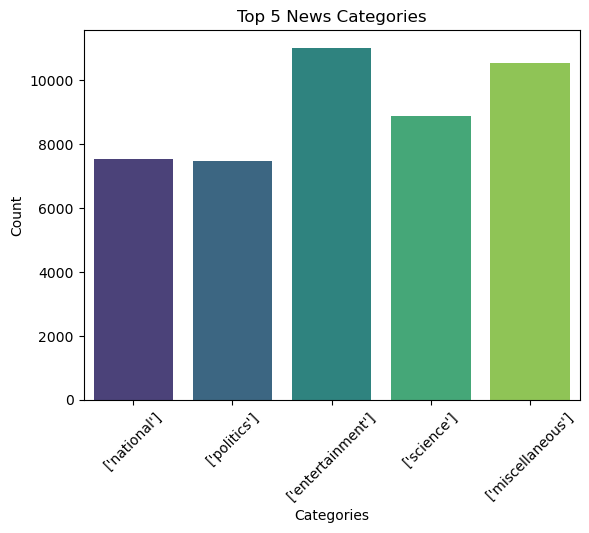

In [16]:
top_n = 5
top_categories = df['News Categories'].value_counts().nlargest(top_n).index

df_top = df[df['News Categories'].isin(top_categories)]

sns.countplot(x='News Categories', data=df_top, palette='viridis')
plt.title(f'Top {top_n} News Categories')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show();

In [17]:
# Construirea și antrenarea modelului
model = make_pipeline(CountVectorizer(), MultinomialNB())
model.fit(X_train, y_train)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [18]:
# Evaluare pe datele de test
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.892
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00         8
           2       1.00      1.00      1.00        11
           3       1.00      0.83      0.91        30
           4       1.00      1.00      1.00         9
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00        18
           9       1.00      0.71      0.83         7
          10       0.00      0.00      0.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00        15
          13       0.00      0.00      0.00         7
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00         6
          16       1.00      1.00      1.

C:\Users\djtsms\Anaconda\envs\semantica\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djtsms\Anaconda\envs\semantica\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\djtsms\Anaconda\envs\semantica\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
#Cross-validation
cv_scores = cross_val_score(model, X, y_encoded, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='accuracy')

print(f"Cross-Validation Scores:{cv_scores}")

print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")

Cross-Validation Scores:[0.88066517 0.88267812 0.87830489]
Mean Accuracy: 0.88


In [20]:
#Fine-tuning
param_dist = {
    'countvectorizer__max_features': [5000, 10000, None],
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': uniform(0.1, 2.0)  # Example range for alpha
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=cv, verbose=1, n_jobs=1)
random_search.fit(X, y_encoded)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=5, n_jobs=1,
                   param_distributions={'countvectorizer__max_features': [5000,
                                                                          10000,
                                                                          None],
                                        'countvectorizer__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000172F1854790>},
                   scoring='accuracy', verbose=1)

In [21]:
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'countvectorizer__max_features': None, 'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 1.2229709721859123}


In [22]:
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_best)

print(f"Best Model Accuracy: {accuracy:.3f}")

Best Model Accuracy: 0.950


In [23]:
# Inverse transform the predicted labels to get the original class labels
predicted_labels_original = le.inverse_transform(y_pred_best)

In [24]:
correct_predictions = sum(y_test == y_pred_best)
wrong_predictions = len(y_test) - correct_predictions
print(f'Correct Predictions: {correct_predictions}, Wrong Predictions: {wrong_predictions}')

Correct Predictions: 37948, Wrong Predictions: 1994


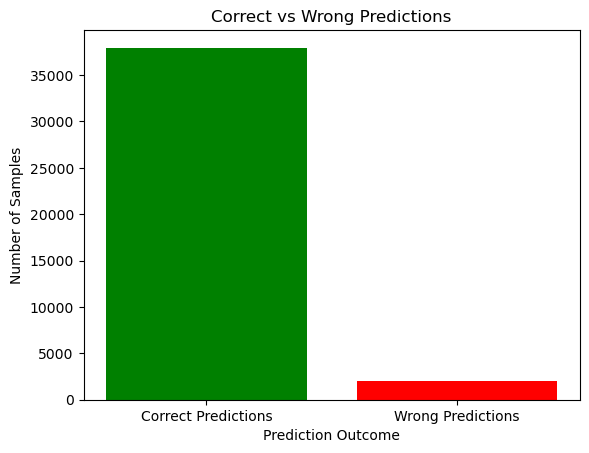

In [25]:
labels = ['Correct Predictions', 'Wrong Predictions']
values = [correct_predictions, wrong_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.title('Correct vs Wrong Predictions')
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.show()

In [26]:
def classify_and_summarize_text_from_web(url):
    """Preprocesează, rezumă și clasifică textul preluat de pe o pagină web."""
    try:
        response = requests.get(url)
        if response.status_code != 200:
            print(f"Eroare la accesarea paginii: {response.status_code}")
            return None

        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        
        # Verificăm dacă există paragrafe de text pe pagină
        if not paragraphs:
            print("Nu au fost găsite paragrafe în pagină.")
            return None

        content = ' '.join([p.get_text() for p in paragraphs])
        if not content.strip():
            print("Textul extras este gol.")
            return None

        processed_text = preprocess_text(content, abbreviation_dict)
        
        # Verificăm dacă există text procesat valid
        if not processed_text.strip():
            print("Textul procesat este gol.")
            return None

        # Clasificare
        predicted_label_encoded = model.predict([processed_text])
        
        if len(predicted_label_encoded) == 0:
            print("Nu s-a putut realiza clasificarea.")
            return None
        
        predicted_label = le.inverse_transform(predicted_label_encoded)

        # Verificăm dacă inversarea etichetelor a dat un rezultat valid
        if len(predicted_label) == 0:
            print("Nu s-a putut inversa eticheta prezisă.")
            return None

        predicted_label = predicted_label[0]

        # Generarea rezumatului
        summary = generate_summary(processed_text)

        return predicted_label, summary

    except Exception as e:
        print(f"Eroare: {e}")
        return None


In [28]:
# Exemplu de utilizare
example_url = 'https://www.cnbc.com/2025/01/09/google-donates-1-million-to-trumps-inauguration-fund.html'
result = classify_and_summarize_text_from_web(example_url)

if result:
    predicted_category, summary = result
    print(f"Categoria prezisă: {predicted_category}")
    print("Rezumatul textului: ")
    print(summary)
else:
    print("Nu s-a putut obține rezultatul.")

Categoria prezisă: ['business']
Rezumatul textului: 
 credit cards loans banking mortgages insurance credit monitoring personal finance small business taxes help low credit scores investing select credit cards find credit card best credit cards best rewardscredit cards best travel credit cardsbest apr credit cardsBest cash back credit cards Best credit cards build credit select loans find best personal loan best debt consolidation loans best loans refinance credit card debt best loans fast funding best small personal loans best large personal loans.
